In [1]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob

import scvi 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
from sklearn.neighbors import NearestNeighbors
from typing import Iterable

# Specific modules
import scanpy as sc
import scanpy.external as sce
import anndata as ad

# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

# Import custom functions
from customPythonFunctions import cumulative_explained_variance, balanced_sample, generateID2SymbolDF


print("Main directory path: {}".format(here()))

#plt.style.use(['science','nature','no-latex'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

overwriteFigures = True
overwriteData = True

Main directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas-R1


### Loading the integrated object

In [2]:
adataHVGint = sc.read_h5ad(here('01_data_processing/SCGT00_CentralizedDataset/results/2_SCGT00_MAIN_normalized_HVGsubset.h5ad'))
adataHVGint

AnnData object with n_obs × n_vars = 855417 × 3126
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm',

### Loading scVI trained model

**Considering Loss function metrics\*, we decided to use the model trained with 512 hidden layers and 30 latent component.** 

Even though the reconstruction loss is lower with 50 latent dimensions, they may include more noise. Thus, we decided to use the model with 30 latent dimensions, as done in the original submission.

For the further rounds of annotation we will reduce the number to 20 for the same reason.

*See wandb report\* (https://api.wandb.ai/links/inflammation/v99jdx0t)*

In [3]:
scviModel = scvi.model.SCVI.load(here(f'01_data_processing/SCGT00_CentralizedDataset/results/3_SCGT00_MAIN_HVGsubset_scVI_step00/'),
                                adata=adataHVGint)

INFO     File                                                                                                      
         /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/01_data_processing/SCGT00_CentralizedDataset/results/3_SCGT00_MAIN_HVG
         subset_scVI_step00/model.pt already downloaded                                                            


In [4]:
adataHVGint.obsm['X_scVI'] = scviModel.get_latent_representation()

## Computing the projections of the embedded space

After integration we have to generate the umap from the embedded space created by scVI.

We will also compute PCA, KNN graph, and UMAP from the non-integrated object for comparsion

### Computing KNN graph and UMAP from the integrated embedded space

In [5]:
n_latent = adataHVGint.obsm['X_scVI'].shape[1]
sc.pp.neighbors(adataHVGint, n_neighbors=20, n_pcs=n_latent, use_rep = 'X_scVI', key_added = 'scVI')

In [6]:
sc.tl.umap(adataHVGint, neighbors_key='scVI')

### Computing the unintegrated Principal Components, KNN graph, and UMAP embedding

In [7]:
# Saving the umap computed on the scVI latent component
adataHVGint.obsm['X_umap_scVI'] = adataHVGint.obsm['X_umap'].copy()
adataHVGint.uns['umap_scVI'] = adataHVGint.uns['umap']

### Feature scaling and centering

Data scaling consist to transform the normalized count matrix to unit variance and zero mean. Normally, data scaling is only performed on HVG, and prior the dimensionaly reduction step (e.g. PCA analysis). 

In [8]:
adataHVGint.X = adataHVGint.layers['log1p_10e4_counts']
sc.pp.scale(adataHVGint, zero_center = True)

### Dimensionality reduction

Following best practices: https://www.sc-best-practices.org/preprocessing_visualization/dimensionality_reduction.html

Luecken, M. D., & Theis, F. J. (2019). Current best practices in single‐cell RNA‐seq analysis: a tutorial. Molecular systems biology, 15(6), e8746

#### PCA

scRNA-seq is data with high dimensions, both in terms of number of cells and genes. However, not all genes are informative neither important for the task of cell type clustering based on their expression profiles.

Here, we perform a dimensionality reduction based on the selected features (HVG) using the Principal Component Analysis (PCA), a hihgly interpretable and computationally efficient algorithm.

The `scanpy.pp.pca` function computes PCA coordinates (by default, 50 PCs), loadings and variance decomposition. Here, while computing PCA on the sparse matrix it computes an implicit mean centering, and using highly variable genes stored in `.var["highly_varible"]` if they have been determined beforehand.

In [9]:
sc.pp.pca(adataHVGint, svd_solver="arpack", use_highly_variable=True, n_comps=50)

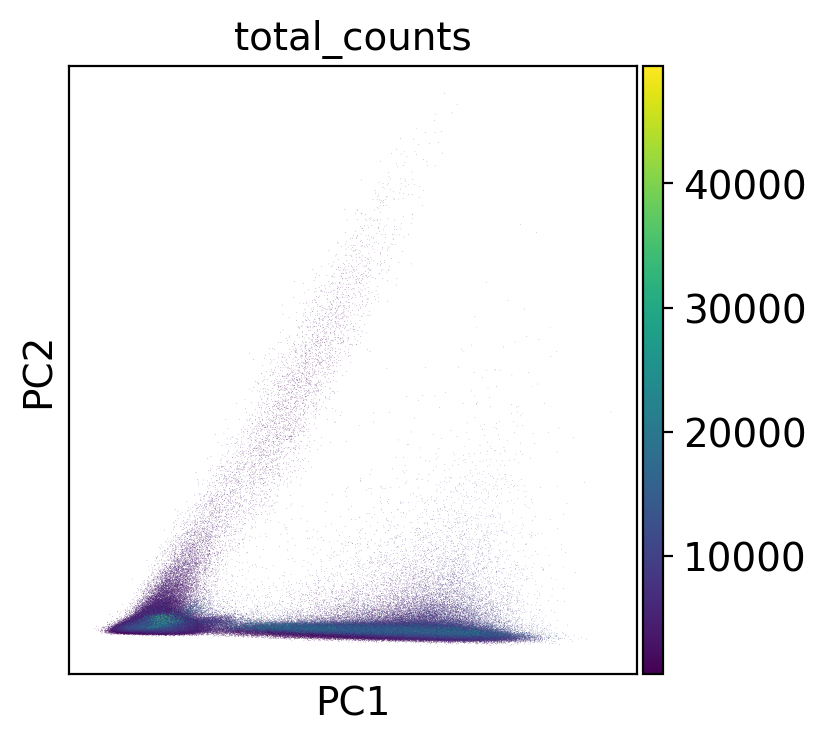

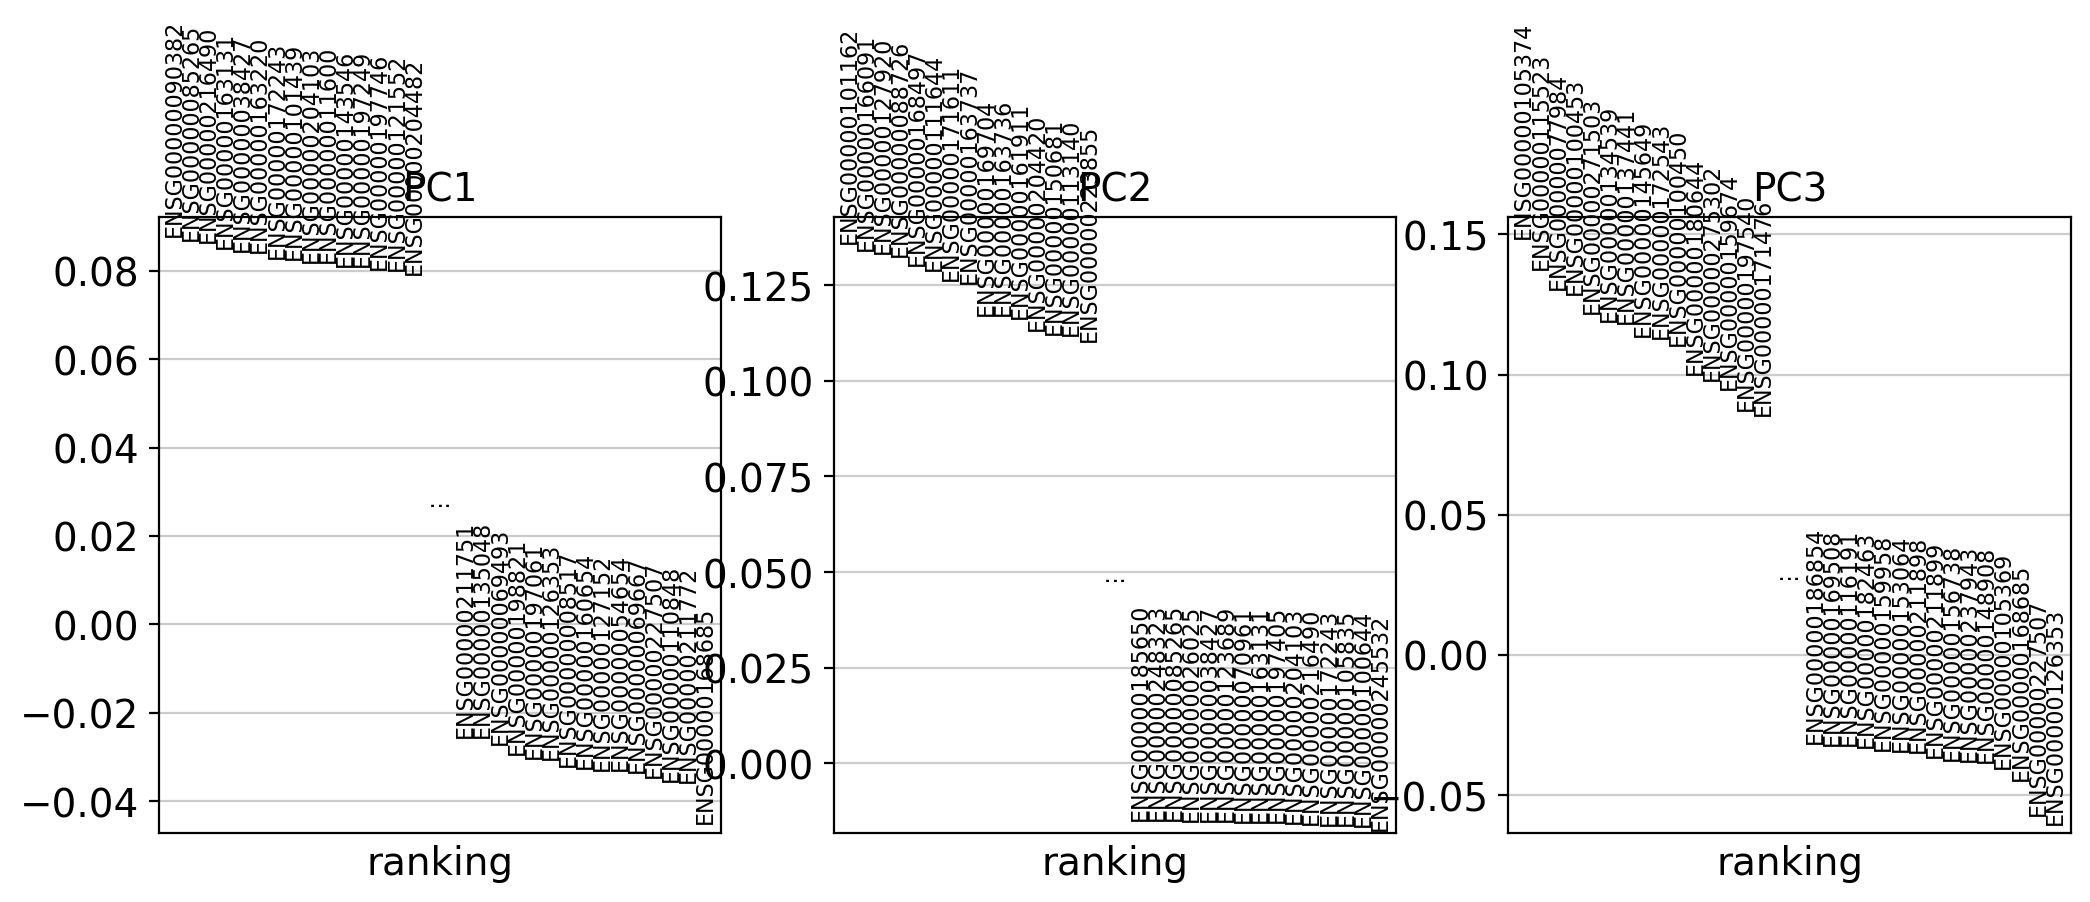

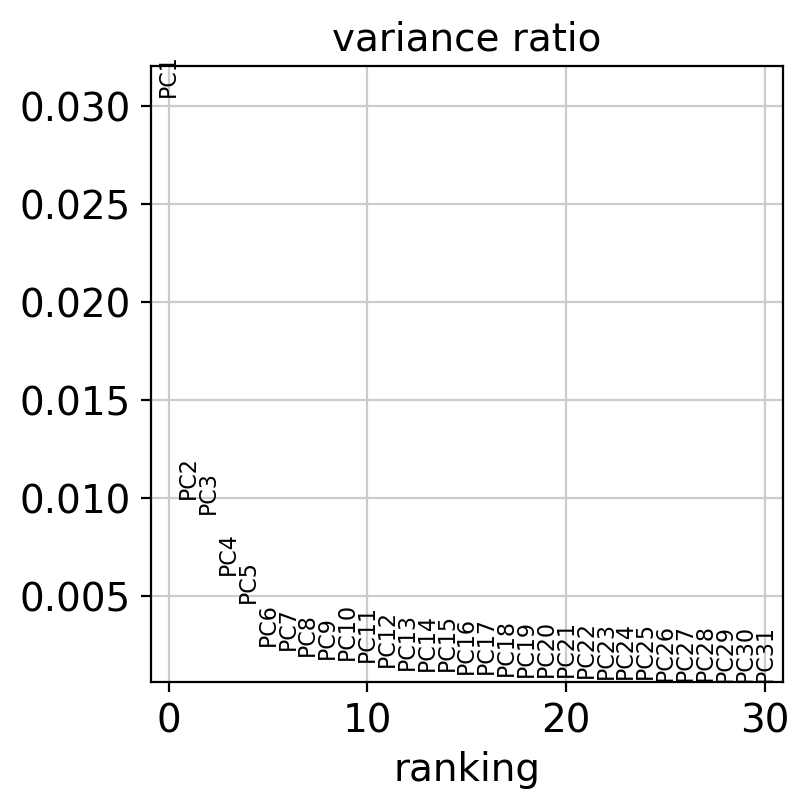

In [10]:
sc.pl.pca_overview(adataHVGint, color="total_counts")

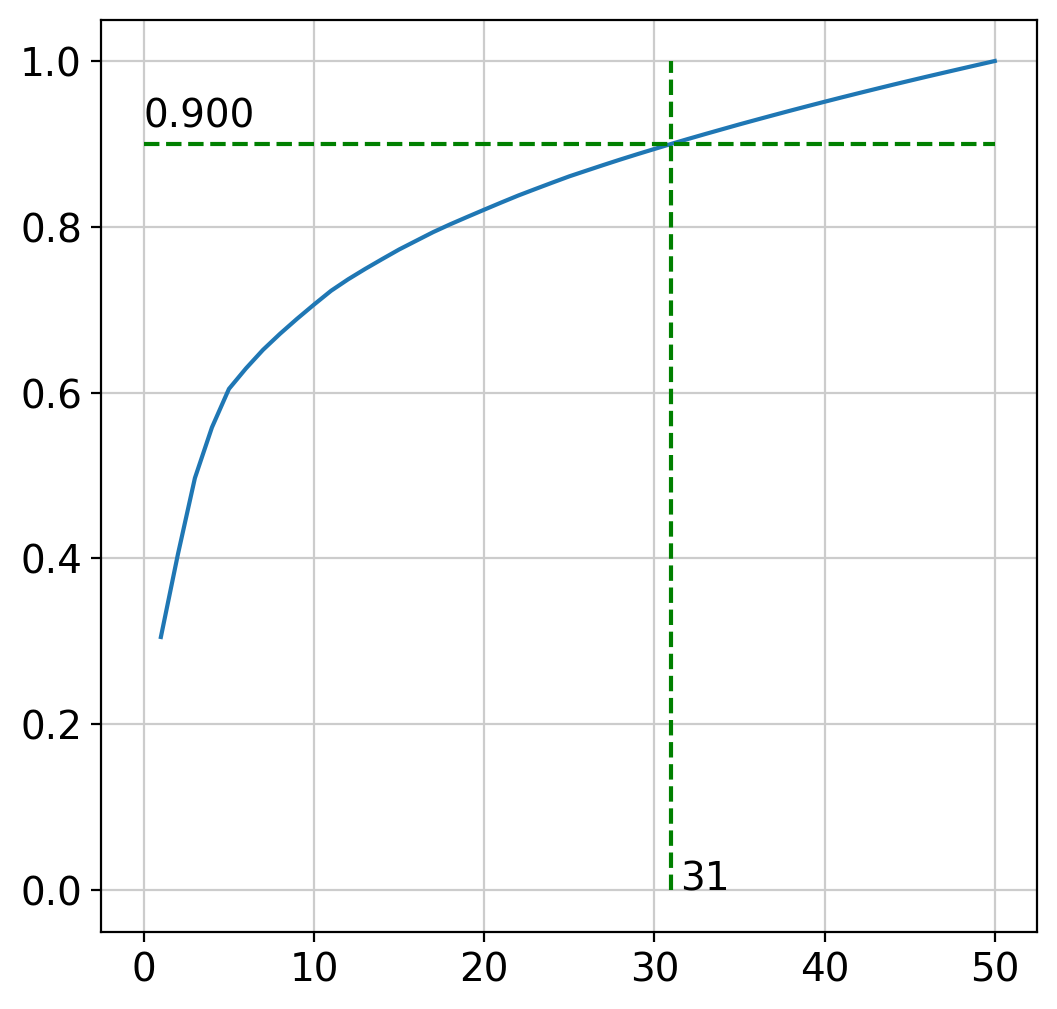

In [11]:
minExpVar = 0.9

res = cumulative_explained_variance(adataHVGint, expVarThr = minExpVar, n_pc=None, figsize=(6,6))

if overwriteFigures:
    plt.savefig(here('01_data_processing/SCGT00_CentralizedDataset/figures/04_cumulative_explainVariance_PCA.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
plt.show()

In [12]:
n_pcs = res['n_pcs']
n_pcs

31

### UMAP

Normally, due to the sparsity and highly non-linear data of scRNA-seq datasets, PCA technique is not very appropriate. Thus, we have used PCA to selected the top Principal Components (PC), which are used for downstream analysis tasks with other dimensionality reduction techniques.

Here, we perform a dimensionality reduction based on the selected Principal Components (PC) selected, using the Uniform Manifold Approximation and Projection (UMAP), a graph based, non-linear dimensionality algorithm that constructs a high dimensional graph and optimizes its low-dimensional representation (2D space); the new reduced embedded space will be used for visualizing high-dimensional data.

In [13]:
sc.pp.neighbors(adataHVGint, n_neighbors=20, n_pcs=n_pcs)

In [14]:
sc.tl.umap(adataHVGint)

In [15]:
adataHVGint.X = adataHVGint.layers['log1p_10e4_counts']

In [16]:
adataHVGint

AnnData object with n_obs × n_vars = 855417 × 3126
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'di

**Loading the full object before HVG subsetting**

This will allows us to inspect genes that are not included in the HV set

In [17]:
adata = sc.read_h5ad(here("01_data_processing/SCGT00_CentralizedDataset/results/2_SCGT00_MAIN_normalized.h5ad"))
adata

AnnData object with n_obs × n_vars = 855417 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'disease_colors', 'log1p'
    layers: 'counts', 'log1

**Merging the objects**

We will transfer the following field to the fullObject: uns, obsm, and obsp. We will also transfer the HVG set

In [18]:
adata.uns = adataHVGint.uns.copy()
adata.obsm = adataHVGint.obsm.copy()
adata.obsp = adataHVGint.obsp.copy()
adata.var['highly_variable'] = False
adata.var['highly_variable'][adata.var_names.isin(adataHVGint.var_names)] = True

In [19]:
# Now we can remove from memory the subsetted adata object
del adataHVGint

## Save the object

In [20]:
if overwriteData:
    adata.write(here("01_data_processing/SCGT00_CentralizedDataset/results/4_SCGT00_MAIN_HVGsubset_scVI_UMAP_clinical_allGenes.h5ad"), compression="gzip")

In [21]:
session_info.show()